
still need to cross validate

# Modelling

Logisitc Regression, Random Forest, xgboost

## Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## Import Data

In [ ]:
#function to load data
def load_json_from_zip(zip_file_path, json_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as myzip:
        # Check if the JSON file exists in the ZIP archive
        if json_file_name in myzip.namelist():
            # Read the JSON data from the ZIP file
            with myzip.open(json_file_name) as json_file:
                data = json.load(json_file)
                # Create a pandas DataFrame from the JSON data
                df = pd.DataFrame(data)
                return df
        else:
            print(f"{json_file_name} not found in the ZIP archive.")
            return None

In [2]:
#declare paths
zip_file_path = 'data.zip'
file_name = 'data/raw_clean_data.json'

#load data
data = load_json_from_zip(zip_file_path, file_name)

In [5]:
data.nunique()

Category                 15
Subcategory             161
Project_Country          15
Launched               4256
Deadline               4208
Project_Currency         15
Goal (USD)            41992
Pledged (USD)         49686
Backers (#)            1000
Status                    4
Duration (days)          95
Year                     12
Month                    12
Subcat_Freq              88
Subcat_Rank              10
Competition             279
Campaign_Count          554
Campaign_Country        464
Campaign_All            140
Campaign_Revenue      47233
Amount_Per_Backer    177552
Amount_Per_Day        81179
Pledge_per_Backer     44181
Pledge_per_Day        81179
dtype: int64

Data Preprocessing - exploratory.ipynb only getting those with relevennt correlations

In [ ]:
#get some data information first
# Convert Deadline and Launched to datetime
data['Deadline'] = pd.to_datetime(data['Deadline'])
data['Launched'] = pd.to_datetime(data['Launched'])

#calculate the duration of campaign in days
data['Duration (days)'] = (data['Deadline'] - data['Launched']).dt.days

#add columns for Year and Month

data['Year'] = data['Launched'].dt.year
data['Month'] = data['Launched'].dt.month_name()

In [ ]:
# get all campaigns per month and Year
campaign_all = data.groupby(['Month', 'Year']).size()

#rename column
campaign_all = campaign_all.rename('Campaign_All')

#reset index
campaign_all = campaign_all.reset_index()

#map to original dataframe

# Create a dictionary from the campaigns data frame, using the common columns as the key and the Campaigns column as the value
campaigns_dict = dict(zip(campaign_all[['Month', 'Year']].itertuples(index=False, name=None), campaign_all['Campaign_All']))

# Map the dictionary to the data data frame, using the same common columns as the key
data['Campaign_All'] = data[['Month', 'Year']].apply(lambda x: campaigns_dict.get(tuple(x)), axis=1)

In [ ]:
#revenue per campaign

#function to get revenue per campaign
# need to calculate fees collected provided campaign is successful

# Kickstarter takes 5% 

def calculate_revenue(pledged, status, fee=0.05):
    return np.where(status == 'Successful', fee * pledged, 0)

In [ ]:
#new feature showing revenue generated from campaign
data['Campaign_Revenue'] = calculate_revenue(data['Pledged (USD)'], data['Status'])

In [ ]:
#calculate revenue or pledged per backer
def amount_per_backer(amount, backers):
    return np.where(backers > 0, amount / backers, 0)


def amount_per_day(amount, duration):
    return np.where(duration > 0, (amount / duration).round(2), 0)

In [ ]:
#pledge per backer
data['Pledge_per_Backer'] = amount_per_backer(data['Pledged (USD)'], data['Backers (#)'])

#pledge per day
data['Pledge_per_Day'] = amount_per_day(data['Pledged (USD)'], data['Duration (days)'])


In [ ]:
#round some new features to two decimal places
data['Pledge_per_Backer'] = data['Pledge_per_Backer'].round(2)
data['Pledge_per_Day'] = data['Pledge_per_Day'].round(2)

In [3]:
#Replace Canceled and Suspended with Failed as I consider campaigns as successful or failed
data['Status'] = data['Status'].replace(['Canceled', 'Suspended'], 'Failed')

In [4]:
#change Status to binary
data['Status'] = data['Status'].replace({'Successful': 1, 'Failed': 0})

From exploratory_analysis.ipynb, we know that the United States accounts for 73% of the data and correlated features with are Target (Status) for this classification.

Will focus on USA only

*For raw data*
Target is Status: Relevant features
- Pledged has a low correlation
- Backers has a mild correlation
- Duration has low negative correlation
- Campaign_all has a low negative correlation
- Campaign revenue has a low correlation - this will not be included as it for a different problem
- pledge per day has a low correlation 

**Focusing on below**
*For Transformed Data*
- Goal has a low - mild negative correlation
- Pledged has a mild correlation
- Backers has a mild correlation
- Duration (days) has a low correlation
- Campaign_all has a low negative correlation
- Campaign Revenue has a low correlation - this is for another problem
- Pledge_per day and per backer have mild correlations

In [5]:
#filter data for USA only
usa_df = data[data['Project_Country'] == 'United States of America']

In [9]:
usa_df.columns

Index(['Category', 'Subcategory', 'Project_Country', 'Launched', 'Deadline',
       'Project_Currency', 'Goal (USD)', 'Pledged (USD)', 'Backers (#)',
       'Status', 'Duration (days)', 'Year', 'Month', 'Subcat_Freq',
       'Subcat_Rank', 'Competition', 'Campaign_Count', 'Campaign_Country',
       'Campaign_All', 'Campaign_Revenue', 'Amount_Per_Backer',
       'Amount_Per_Day', 'Pledge_per_Backer', 'Pledge_per_Day'],
      dtype='object')

In [6]:
#drop low correlation columns
usa = usa_df[['Goal (USD)', 'Pledged (USD)', 'Backers (#)', 'Duration (days)', 'Campaign_All', 'Pledge_per_Day', 'Pledge_per_Backer', 'Status']]
usa


,Goal (USD),Pledged (USD),Backers (#),Duration (days),Campaign_All,Pledge_per_Day,Pledge_per_Backer,Status
0,100000000,0,0,60,4375,0.00,0.00,0
1,100000000,85,4,57,2344,1.49,21.25,0
3,100000000,1,1,31,3879,0.03,1.00,0
5,100000000,1,1,60,4813,0.02,1.00,0
6,100000000,0,0,60,6925,0.00,0.00,0
...,...,...,...,...,...,...,...,...
506194,1,0,0,30,7565,0.00,0.00,0
506195,0,100,6,9,227,11.11,16.67,1
506196,0,0,0,36,2659,0.00,0.00,0
506197,0,0,0,51,2977,0.00,0.00,0


In [7]:
#function to declar var
def declare_var(dataframe, target):
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    return X, y

#split data
def split_data(X_var, y_var):
    X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, shuffle=True, test_size=0.3, stratify=y_var)
    return X_train, X_test, y_train, y_test

#handle outliers in column
def column_winsorization(dataframe, lower_limit, upper_limit, axis=None):
    clipped = dataframe.clip(dataframe.quantile(lower_limit), dataframe.quantile(upper_limit), axis=axis)
    return clipped

#apply quantile transformer
def quantile_transformation(data):
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    qt_data = qt.fit_transform(data.values.reshape(-1, 1))
    return qt_data

In [8]:
#function to eval
def eval_model(actual_data, predict_data):
    report = classification_report(actual_data, predict_data)
    logloss = log_loss(actual_data, predict_data)
    print(f"Here is your classification report value:\n", report)
    print(f"Here is your log loss value: {logloss}")

In [9]:
#declare variables
X, y = declare_var(usa, 'Status')

In [10]:
#split data in train and test
X_train, X_test, y_train, y_test = split_data(X, y)

# Feature Selection

In [18]:
#transform X_train for selectkbest and PCA
#X columns
my_col = list(X_train.columns)

#make copy of X_train
X_transformed = X_train.copy()

#apply winsorization and quantile transformation
for col in my_col:
    X_transformed[col] = column_winsorization(X_transformed[col], lower_limit=0.1, upper_limit=0.9)
    X_transformed[col] = quantile_transformation(X_transformed[col])


## Raw data

In [34]:
#initialize scaler and selector
scaler = StandardScaler()
selector = SelectKBest(f_classif, k='all')

#scale train data only - exploration purposes
scaled = scaler.fit_transform(X_train)

In [39]:
#fit selector on scaled train data
selector.fit_transform(scaled, y_train)

array([[ 0.29965607,  0.1019782 ,  0.1348495 , ..., -0.48464038,
         0.232195  ,  0.09103738],
       [ 0.15167525,  0.45042725,  0.37865022, ..., -0.32613799,
         0.40651389,  0.46580295],
       [-0.38099882, -0.31320853, -0.17920064, ..., -0.28252803,
        -0.31896471, -0.36173998],
       ...,
       [ 2.12479674,  2.13300697,  0.31852315, ..., -0.15563495,
         2.13406047,  2.13058867],
       [ 0.0371597 ,  0.41479473,  0.11629881, ..., -0.12376939,
         0.33980431,  2.13058867],
       [-0.15618091,  0.22644099,  0.24077243, ..., -0.44613329,
         0.17696175,  0.17851493]])

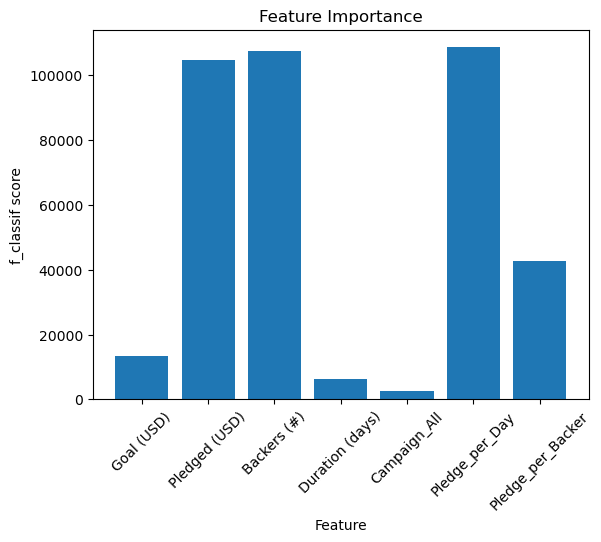

In [40]:
#get feature names and scores
feature_names = list(X.columns)
scores = selector.scores_


#plot scores
plt.bar(range(len(scores)), scores)
plt.xlabel("Feature")
plt.ylabel("f_classif score")
plt.title("Feature Importance")
plt.xticks(range(len(scores)), feature_names, rotation=45)
plt.show()

## Transformed data

In [41]:
#scale transformed data
scaled = scaler.fit_transform(X_transformed)

In [42]:
#fit on transformed data
selector.fit_transform(scaled, y_train)

array([[ 0.29965607,  0.1019782 ,  0.1348495 , ..., -0.48464038,
         0.232195  ,  0.09103738],
       [ 0.15167525,  0.45042725,  0.37865022, ..., -0.32613799,
         0.40651389,  0.46580295],
       [-0.38099882, -0.31320853, -0.17920064, ..., -0.28252803,
        -0.31896471, -0.36173998],
       ...,
       [ 2.12479674,  2.13300697,  0.31852315, ..., -0.15563495,
         2.13406047,  2.13058867],
       [ 0.0371597 ,  0.41479473,  0.11629881, ..., -0.12376939,
         0.33980431,  2.13058867],
       [-0.15618091,  0.22644099,  0.24077243, ..., -0.44613329,
         0.17696175,  0.17851493]])

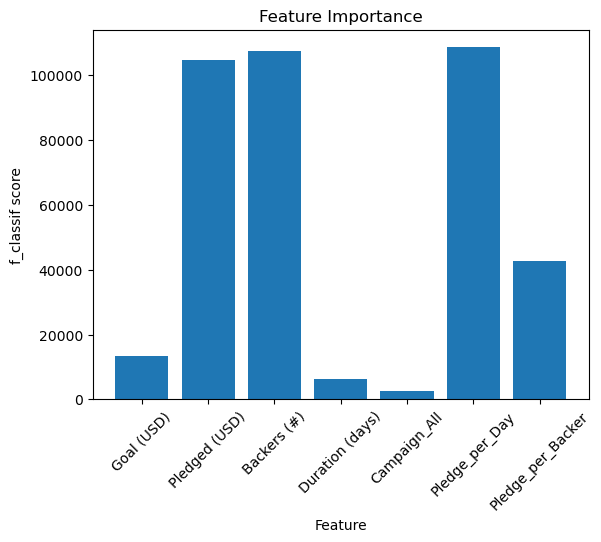

In [43]:
#get feature names and scores
feature_names = list(X.columns)
scores = selector.scores_


#plot scores
plt.bar(range(len(scores)), scores)
plt.xlabel("Feature")
plt.ylabel("f_classif score")
plt.title("Feature Importance")
plt.xticks(range(len(scores)), feature_names, rotation=45)
plt.show()

# PCA

## Raw data

In [44]:
#scale raw data
scaled = scaler.fit_transform(X_train)

In [45]:
#initialize object
pca = PCA()

In [46]:
#fit data
pca.fit(scaled, y_train)

PCA()

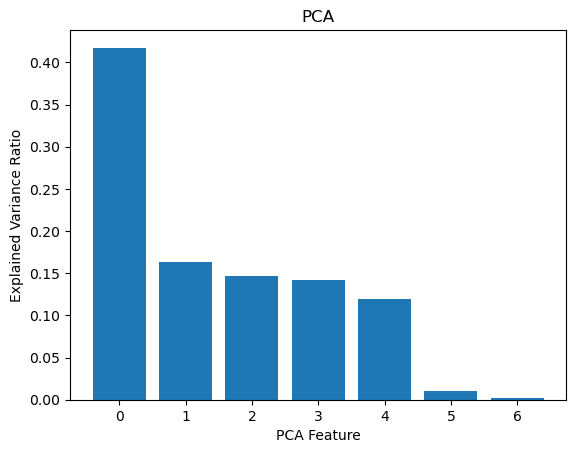

In [47]:
#plot pca
pca_scores = pca.explained_variance_ratio_

plt.bar(range(len(pca_scores)), pca_scores)
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA')
plt.show()


## Transformed data

In [48]:
#scale transformed data
scaled = scaler.fit_transform(X_transformed)

In [49]:
#fit on transformed data
pca.fit(scaled, y_train)

PCA()

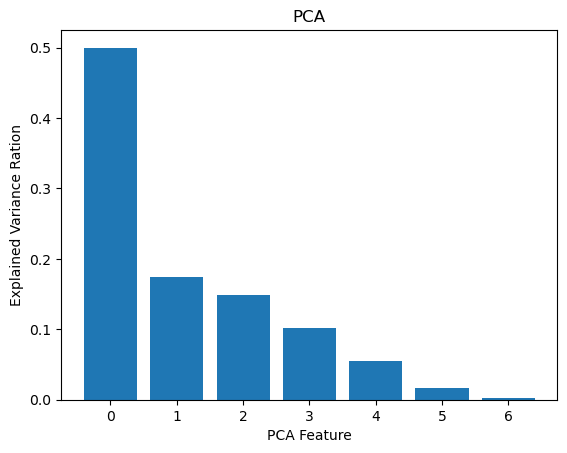

In [50]:
#plot pca
pca_scores = pca.explained_variance_ratio_

plt.bar(range(len(pca_scores)), pca_scores)
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance Ration')
plt.title('PCA')
plt.show()

On the transformed data, it appears 3 components anf 4 features important.

## PCA - 3 components only

In [51]:
#need to update this part pca first then selectkbest

#scale transformed data
scaled = scaler.fit_transform(X_transformed)


#initialize new pca with 3 components
pca_3 = PCA(n_components=3)

#fit pca on new
pca_3.fit_transform(scaled, y_train)

array([[ 0.3903505 ,  1.30821744, -0.04064011],
       [ 0.86753329, -0.31820262,  0.2758812 ],
       [-0.60852485,  0.05961147,  0.44313781],
       ...,
       [ 3.51615855, -2.87778371, -0.4291373 ],
       [ 1.42536381, -0.36307763,  0.11144103],
       [ 0.40876783, -0.16664296,  0.51608712]])

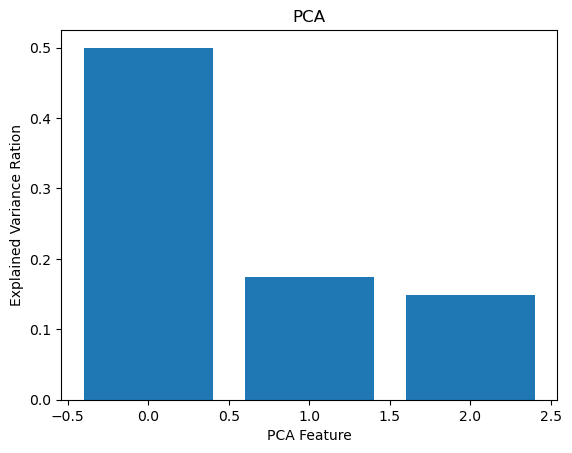

In [52]:
pca_scores = pca_3.explained_variance_ratio_

plt.bar(range(len(pca_scores)), pca_scores)
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance Ration')
plt.title('PCA')
plt.show()

# Logistic Regression

Base model will be raw data no transformations
Base+ will have transformation
optimize models - select best features, grid search, cross validation too

## Base Model

In [28]:
#declare steps
pipeline = Pipeline(steps=
    [('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga'))])

In [29]:
#fit data on pipeline
pipeline.fit(X_train, y_train)

/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

In [30]:
#predict
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [31]:
#eval train mode
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86    156930
           1       0.86      0.63      0.73    102430

    accuracy                           0.81    259360
   macro avg       0.83      0.78      0.79    259360
weighted avg       0.82      0.81      0.81    259360

Here is your log loss value: 6.748873918629302


In [32]:
# eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86     67256
           1       0.86      0.63      0.72     43899

    accuracy                           0.81    111155
   macro avg       0.83      0.78      0.79    111155
weighted avg       0.82      0.81      0.80    111155

Here is your log loss value: 6.78134967681712


So virtually identical with the raw data. Will try again with transformed data.

## Base+ model - data is transformed with winsorization and quantile transformation

In [13]:
#declare columns to transform
columns_to_transform = ['Goal (USD)', 'Pledged (USD)', 'Backers (#)',
 'Duration (days)', 'Campaign_All', 'Pledge_per_Day', 'Pledge_per_Backer']

In [17]:
#create transformers
winsorizer = FunctionTransformer(func=column_winsorization, kw_args={'lower_limit': 0.1, 'upper_limit': 0.9, 'axis': 1})
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)

In [18]:
#column transformer
transformer = ColumnTransformer(
    transformers=[('winsorize', winsorizer, columns_to_transform),
                  ('quantile', quantile_transformer, columns_to_transform)], remainder='passthrough')

In [51]:
pipeline = pipeline = Pipeline(steps=
    [('transformer', transformer), 
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='saga'))])

In [42]:
print(X_train.shape)
print(y_train.shape)

(259360, 7)
(259360,)


In [52]:
#Fit data
pipeline.fit(X_train, y_train)

/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7fba6ed899e0>,
                                                                      kw_args={'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

In [53]:
#predict
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [54]:
#eval train mode
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    156930
           1       0.98      1.00      0.99    102430

    accuracy                           0.99    259360
   macro avg       0.99      0.99      0.99    259360
weighted avg       0.99      0.99      0.99    259360

Here is your log loss value: 0.36285463833661685


In [55]:
# eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     67256
           1       0.98      1.00      0.99     43899

    accuracy                           0.99    111155
   macro avg       0.99      0.99      0.99    111155
weighted avg       0.99      0.99      0.99    111155

Here is your log loss value: 0.3618795122329609


Mhmm again identical for the most part. The log loss is less for the test data than the train, but not enough to distinguish the results.

I don't think LogisticRegression is the way to go

## Base+ - SelectKbest

In [22]:
#initialize pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(k=3)),
    ('classifier', LogisticRegression(solver='saga'))
])

In [23]:
#fit pipeline on train data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()), ('kbest', SelectKBest(k=3)),
                ('classifier', LogisticRegression(solver='saga'))])

In [24]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [25]:
# eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86    156930
           1       0.84      0.65      0.74    102430

    accuracy                           0.81    259360
   macro avg       0.82      0.79      0.80    259360
weighted avg       0.82      0.81      0.81    259360

Here is your log loss value: 6.6893941081321495


In [26]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86     67256
           1       0.85      0.65      0.74     43899

    accuracy                           0.82    111155
   macro avg       0.82      0.79      0.80    111155
weighted avg       0.82      0.82      0.81    111155

Here is your log loss value: 6.642888608964546


The model performed better on test data by 0.01%, but not a big difference. Could be a candidate for gridsearch later on.

## Base+ - PCA

In [27]:
#declare pipeline with transformer(from above), selectkbest, pca, standard scaler, classifier
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', LogisticRegression(solver='saga'))
])

In [29]:
#fit data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('classifier', LogisticRegression(solver='saga'))])

In [30]:
#get prediction
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [31]:
#eval train data
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90    156930
           1       0.85      0.85      0.85    102430

    accuracy                           0.88    259360
   macro avg       0.87      0.87      0.87    259360
weighted avg       0.88      0.88      0.88    259360

Here is your log loss value: 4.3442497106099704


In [32]:
#eval test data
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     67256
           1       0.85      0.85      0.85     43899

    accuracy                           0.88    111155
   macro avg       0.88      0.88      0.88    111155
weighted avg       0.88      0.88      0.88    111155

Here is your log loss value: 4.290023249858485


PCA was a bit better select k best. The model had a lower log loss value on the test data than the train data. Could be promising

# Ignore - Gridsearch for later

In [17]:
#IGNORE FOR NOW LATER USE!!!!!!
# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__l1_ratio': [0.1, 0.5, 0.9]
}


# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [18]:
# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train)

/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/sbangarh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__l1_ratio': [0.1, 0.5, 0.9],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet']})

In [19]:
# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'classifier__C': 10, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'l1'}
Best score:  0.8800046267735965


In [22]:
#select best parameters
best_params = grid_search.best_params_

In [51]:
#update pipeline parameters
pipeline.set_params(**best_params)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='l1',
                                    solver='saga'))])

# Random Forest

## Base Model -scale and model

In [56]:
#declare pipeline and steps
pipeline = pipeline = Pipeline(steps=
    [('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())])

In [57]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [58]:
#predict
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [59]:
#eval train mode
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    156930
           1       1.00      1.00      1.00    102430

    accuracy                           1.00    259360
   macro avg       1.00      1.00      1.00    259360
weighted avg       1.00      1.00      1.00    259360

Here is your log loss value: 0.0008338291191192184


In [60]:
# eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     67256
           1       0.99      1.00      0.99     43899

    accuracy                           0.99    111155
   macro avg       0.99      1.00      0.99    111155
weighted avg       0.99      0.99      0.99    111155

Here is your log loss value: 0.18645225764691098


## Base+ - transformed data

In [61]:
#declare steps in pipeline. transformer was declared in LogisticRegression section.
pipeline = pipeline = Pipeline(steps=
    [('transformer', transformer), 
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())])

In [62]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7fba6ed899e0>,
                                                                      kw_args={'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [63]:
#predict data
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [64]:
#eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    156930
           1       1.00      1.00      1.00    102430

    accuracy                           1.00    259360
   macro avg       1.00      1.00      1.00    259360
weighted avg       1.00      1.00      1.00    259360

Here is your log loss value: 0.0012507436786787164


In [65]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     67256
           1       0.99      1.00      0.99     43899

    accuracy                           1.00    111155
   macro avg       0.99      1.00      0.99    111155
weighted avg       1.00      1.00      1.00    111155

Here is your log loss value: 0.17704857856558848


Wow, more overfitting it appears. Will likely have to explore PCA and feature selection

## Base+ -Selectkbest

In [33]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(k=3)),
    ('classifier', RandomForestClassifier())
])

In [34]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()), ('kbest', SelectKBest(k=3)),
                ('classifier', RandomForestClassifier())])

In [35]:
#predicit
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [36]:
#eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    156930
           1       0.97      0.98      0.97    102430

    accuracy                           0.98    259360
   macro avg       0.98      0.98      0.98    259360
weighted avg       0.98      0.98      0.98    259360

Here is your log loss value: 0.7635095300732948


In [37]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86     67256
           1       0.77      0.82      0.80     43899

    accuracy                           0.83    111155
   macro avg       0.83      0.83      0.83    111155
weighted avg       0.84      0.83      0.84    111155

Here is your log loss value: 5.957717095211637


model performed much worse on test data by a magnitude of 0.15

## Base+ PCA 3 components

In [38]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', RandomForestClassifier())
])

In [39]:
#fit data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer'])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('classifier', RandomForestClassifier())])

In [40]:
#predict 
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [41]:
#eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    156930
           1       1.00      1.00      1.00    102430

    accuracy                           1.00    259360
   macro avg       1.00      1.00      1.00    259360
weighted avg       1.00      1.00      1.00    259360

Here is your log loss value: 0.0018066297580913806


In [42]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     67256
           1       0.88      0.89      0.89     43899

    accuracy                           0.91    111155
   macro avg       0.91      0.91      0.91    111155
weighted avg       0.91      0.91      0.91    111155

Here is your log loss value: 3.254645756525292


Yeah, once again there is overfitting.

# XGBoost

## Base model - scale and model

In [44]:
from xgboost import XGBClassifier

In [67]:
#declare pipeline and steps
pipeline = Pipeline(steps=
    [('scaler', StandardScaler()),
    ('classifier', XGBClassifier())])

In [68]:
#train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [69]:
#predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [70]:
#eval train
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    156930
           1       0.99      1.00      1.00    102430

    accuracy                           1.00    259360
   macro avg       1.00      1.00      1.00    259360
weighted avg       1.00      1.00      1.00    259360

Here is your log loss value: 0.13188397234065488


In [71]:
#eval test
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     67256
           1       0.99      1.00      0.99     43899

    accuracy                           1.00    111155
   macro avg       0.99      1.00      1.00    111155
weighted avg       1.00      1.00      1.00    111155

Here is your log loss value: 0.17186034183106577


Overfitting

## Base+ - Transformed data

In [73]:
pipeline = Pipeline(steps=
    [('transfomer', transformer),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier())])

In [74]:
#fit the data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transfomer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7fba6ed899e0>,
                                                                      kw_args={'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile',
                                                  Quantile...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [75]:
# get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [76]:
#eval train
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    156930
           1       0.99      1.00      1.00    102430

    accuracy                           1.00    259360
   macro avg       1.00      1.00      1.00    259360
weighted avg       1.00      1.00      1.00    259360

Here is your log loss value: 0.13188397234065488


In [77]:
#eval test
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     67256
           1       0.99      1.00      0.99     43899

    accuracy                           1.00    111155
   macro avg       0.99      1.00      1.00    111155
weighted avg       1.00      1.00      1.00    111155

Here is your log loss value: 0.17186034183106577


same results...will have to explore PCA and feature selection

## Base+ selectkbest 3

In [47]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(k=3)),
    ('classifier', XGBClassifier())
])

In [48]:
#fit data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [49]:
#predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [50]:
#eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88    156930
           1       0.80      0.87      0.84    102430

    accuracy                           0.86    259360
   macro avg       0.86      0.87      0.86    259360
weighted avg       0.87      0.86      0.87    259360

Here is your log loss value: 4.897356359625572


In [51]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88     67256
           1       0.79      0.86      0.83     43899

    accuracy                           0.86    111155
   macro avg       0.85      0.86      0.85    111155
weighted avg       0.86      0.86      0.86    111155

Here is your log loss value: 5.200883061563132


not great at all

## Base+ pca 3 components

In [52]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', XGBClassifier())
])

In [53]:
#fit data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorize',
                                                  FunctionTransformer(func=<function column_winsorization at 0x7f44bcf77ba0>,
                                                                      kw_args={'axis': 1,
                                                                               'lower_limit': 0.1,
                                                                               'upper_limit': 0.9}),
                                                  ['Goal (USD)',
                                                   'Pledged (USD)',
                                                   'Backers (#)',
                                                   'Duration (days)',
                                                   'Campaign_All',
                                                   'Pledge_per_Day',
                                                   'Pledge_per_Backer']),
                                                 ('quantile...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [54]:
#predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [55]:
#eval train model
eval_model(y_train, train_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93    156930
           1       0.88      0.90      0.89    102430

    accuracy                           0.91    259360
   macro avg       0.91      0.91      0.91    259360
weighted avg       0.91      0.91      0.91    259360

Here is your log loss value: 3.1345026302881607


In [56]:
#eval test model
eval_model(y_test, test_pred)

Here is your classification report value:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     67256
           1       0.88      0.89      0.88     43899

    accuracy                           0.91    111155
   macro avg       0.90      0.91      0.90    111155
weighted avg       0.91      0.91      0.91    111155

Here is your log loss value: 3.3162560677477497


: 